In [37]:
# imports

import requests
import pandas as pd
import json
import html
import os.path
import numpy as np
from scipy import stats

In [38]:
def retrieveCfbData(endpoint, team, year, week):
    file_path = f"data/{endpoint if (endpoint != 'plays') else 'pbp'}/{endpoint[:-1] if (endpoint != 'plays') else 'pbp'}-data-{team.lower().replace(' ','-')}-{year}-wk{week}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/{endpoint}?seasonType=regular&year={year}&team={html.escape(team)}&week={week}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)

def retrieveRemoteCfbGame(game_id, year):
    file_path = f"data/games/game-data-{game_id}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/games?year={year}&seasonType=regular&id={game_id}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)
    

In [39]:
# init data retrieval
teams = pd.read_csv("data/teams/2018.csv", encoding = 'latin-1')

base_drives = pd.DataFrame()
games = pd.DataFrame()
pbp_data = pd.DataFrame()

def retrieveCfbDataFile(endpoint, year):
    return pd.read_csv(f"data/{endpoint}/{year}.csv", encoding='latin-1')

for i in range(2016, 2020):
    drive = retrieveCfbDataFile('drives',i)
    drive['year'] = i
    base_drives = base_drives.append(drive)
    
    gm = retrieveCfbDataFile('games',i)
    gm['year'] = i
    games = games.append(gm)
    
    plys = retrieveCfbDataFile('pbp',i)
    plys['year'] = i
    pbp_data = pbp_data.append(plys)

/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [40]:
print(f"Total Games: {len(games)}")
print(f"Total Drives: {len(base_drives)}")
print(f"Total Plays: {len(pbp_data)}")

# print(f"2016 Drives: {len(base_drives[base_drives.game_id == 400868979])}")
# base_drives[base_drives.offense == 'Ole Miss']

Total Games: 3289
Total Drives: 84218
Total Plays: 595530


In [41]:
# Data cleaning

games.reset_index(inplace = True) 
pbp_data.reset_index(inplace = True) 
base_drives.reset_index(inplace = True) 

base_drives = base_drives[
    (~base_drives.drive_result.isin(['Uncategorized']))
]
base_drives.drop(['offense_conference','start_time.minutes','start_time.seconds','end_time.minutes','end_time.seconds','defense_conference','elapsed.seconds','elapsed.minutes'], axis = 1, inplace=True) 
drives = pd.merge(base_drives, games[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
drives.rename(columns={'id_x':'drive_id'}, inplace=True)
drives.drop(['id_y'], axis = 1, inplace=True)
drives.dropna(inplace=True)
print(f"Clean Drives: {len(drives)}")

drives.loc[
    drives.offense == drives.away_team, ['start_yardline']
] = 100 - drives.start_yardline
drives.loc[
    drives.offense == drives.away_team, ['end_yardline']
] = 100 - drives.end_yardline
pbp_data = pbp_data[
    (pbp_data.down != 0)
]

Clean Drives: 83699


In [42]:
pbp_data.distance = pbp_data.distance.astype(float)

pbp_data.drop(['offense_conference','defense_conference'], axis = 1, inplace=True) 
# Ignore some types of plays cause they're special teams and weird
ignore_types = ["Defensive 2pt Conversion","Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Timeout","End of Half","End of Game","Uncategorized","Penalty","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt", "Field Goal Good","Field Goal Missed","Safety"]
pbp_data = pbp_data[~(pbp_data.play_type.isin(ignore_types)) & ~(pbp_data.play_text.str.contains("Penalty").astype(bool))]

bad_types = ["Interception","Pass Interception Return","Interception Return Touchdown",'Fumble Recovery (Opponent)','Sack','Fumble Return Touchdown']
pbp_data.loc[
    ((pbp_data.play_type.isin(bad_types))
     & (~pbp_data.play_type.str.contains('Sack'))) ,['yards_gained']] = 0

In [51]:
def verify_division(num1, num2):
    if num2 == 0:
        return 0
    else:
        return num1 / num2
    
def calculate_success_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    success = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.drive_id == opp_id) & (pbp.offense == team)]
        opp_s_rate = verify_division(len(opp_set[opp_set.play_successful == True]), len(opp_set))
        success += len(opp_set[opp_set.play_successful == True])
        total += len(opp_set)
    s_rate = 0 if total == 0 else (success / total)
    return s_rate

def calculate_score_value(drv):
    if (drv.drive_result == 'TD'):
        return 7
    elif (drv.drive_result == 'FG'):
        return 3
    elif (drv.drive_result == 'SAFETY'):
        return -2
    elif ((drv.drive_result == 'INT TD') | (drv.drive_result == 'FUMBLE TD')):
        return -7
    else:
        return 0

def calculate_ppd_in_scoring_opps(opps, team):
    scores = 0
    total = len(opps)
    scores = opps.apply(lambda x: calculate_score_value(x), axis = 1)
    ppd = 0 if total == 0 else (sum(scores) / total)
    return ppd
    
def is_successful(down, distance, yards_gained, play_type):
    if (play_type in bad_types):
        return False 
    if ((down == 1) & (yards_gained >= (0.5 * distance))):
        return True
    elif ((down == 2)) & (yards_gained >= (0.7 * distance)):
        return True
    elif ((down == 3) & (yards_gained >= distance)):
        return True
    elif ((down == 4) & (yards_gained >= distance)):
        return True
    else:
        return False
    
def is_successful_vector(play):
    if (play.play_type in bad_types):
        return False 
    if ((play.down == 1) & (play.yards_gained >= (0.5 * play.distance))):
        return True
    elif ((play.down == 2)) & (play.yards_gained >= (0.7 * play.distance)):
        return True
    elif ((play.down == 3) & (play.yards_gained >= play.distance)):
        return True
    elif ((play.down == 4) & (play.yards_gained >= play.distance)):
        return True
    else:
        return False

def is_explosive(yards_gained):
    if (yards_gained >= 15):
        return True
    else:
        return False
    
pbp_data['play_explosive'] = np.vectorize(is_explosive)(pbp_data.yards_gained)
pbp_data['play_successful'] = np.vectorize(is_successful)(pbp_data.down, pbp_data.distance, pbp_data.yards_gained, pbp_data.play_type)
    
def calculate_success_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_successful == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
def calculate_exp_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_explosive == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
standard_downs = pbp_data[
    (pbp_data.down == 1)
    | ((pbp_data.down == 2) & (pbp_data.distance <= 7))
    | ((pbp_data.down == 3) & (pbp_data.distance <= 4))
    | ((pbp_data.down == 4) & (pbp_data.distance <= 4)) 
]

passing_downs = pbp_data[
    ((pbp_data.down == 2) & (pbp_data.distance >= 8))
    | ((pbp_data.down == 3) & (pbp_data.distance >= 5))
    | ((pbp_data.down == 4) & (pbp_data.distance >= 5)) 
]

pass_types = ["Pass Reception","Pass Incompletion","Passing Touchdown","Interception","Pass Interception Return","Interception Return Touchdown","Sack"]
rush_types = ["Rush","Rushing Touchdown",'Fumble Recovery (Opponent)','Fumble Return Touchdown']

In [97]:
def generate_team_play_stats(pbp, team):
    team_off_plays = pbp[pbp.offense == team]
    off_sr = calculate_success_rate(team_off_plays, [])
    off_er = calculate_exp_rate(team_off_plays, [])
    ypp = verify_division(sum(team_off_plays.yards_gained), len(team_off_plays))
    return pd.DataFrame({
        'team': [team],
        "OffSR": [off_sr],
        "OffER" : [off_er],
        "YPP" : [ypp]
    })

def generate_team_drive_stats(drvs, pbp, gm, points, team):
    team_drives = drvs[drvs.offense == team]
    scoring_opps = team_drives[
        ((team_drives.start_yardline + team_drives.yards) >= 60)
    ]
    avg_fp = verify_division(sum(team_drives.start_yardline), len(team_drives))
    ppd = verify_division(points, len(team_drives))
    opp_effcy = verify_division(len(scoring_opps[scoring_opps.scoring == True]), len(scoring_opps))
    opp_rate = verify_division(len(scoring_opps), len(team_drives))
    opp_sr = calculate_success_in_scoring_opps(pbp, scoring_opps, team)
    opp_ppd = calculate_ppd_in_scoring_opps(scoring_opps, team)
    return pd.DataFrame({
        'team': [team],
        'FP': [avg_fp],
        'PPD': [ppd],
        'OppEff': [opp_effcy],
        'OppRate': [opp_rate],
        'OppSR': [opp_sr],
        'OppPPD': [opp_ppd]
    })

def calculate_havoc_rate(pbp, team):
    team_havoc = pbp[(pbp.defense == team) & ((((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type == 'Fumble Recovery (Opponent)')
        | (pbp.play_type == 'Sack')
        | (pbp.play_type.str.contains('Interception', regex=False))
        | (pbp.yards_gained < 0))
        & (pbp.play_type != 'Penalty'))]
    return verify_division(len(team_havoc), len(pbp[(pbp.defense == team)]))

def generate_team_turnover_stats(pbp, team):
    adj_turnover_plays = pbp[
        (pbp.play_type.str.contains('Interception', regex=False))
        | ((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type.str.contains('Fumble', regex=False))
    ]

    fum_plays = adj_turnover_plays[
        (adj_turnover_plays.play_type.str.contains('Fumble', regex=False))
    ]

    # away_team Adj Turnovers
    team_tos = adj_turnover_plays[
        (adj_turnover_plays.offense == team)
        | (adj_turnover_plays.defense == team)
    ]

    team_ints_off = team_tos[
       (team_tos.play_type.str.contains('Interception', regex=False))
        & (team_tos.offense == team)
    ]

    team_pds = team_tos[
       (team_tos.play_type == 'Pass Incompletion')
        & (team_tos.play_text.str.contains('broken up', regex=False))
        & (team_tos.offense == team)
    ]
    
    exp_to = (0.22 * (len(team_pds) + len(team_ints_off))) + (0.49 * len(fum_plays))
    havoc = calculate_havoc_rate(pbp, team)

    return pd.DataFrame({
        'team' : [team],
        'ExpTO': [exp_to],
        'HavocRate': [havoc]
    })

def stringify_entry(team_entry):
    entries = team_entry.tolist()
    return entries[0]

def calculate_five_factors_rating(team_stat_pack):
    return (35 * team_stat_pack.OffSR) + (25 * (team_stat_pack.YPP / 10)) + (15 * (team_stat_pack.FP / 50.0)) + (15 * ((((team_stat_pack.OppPPD + team_stat_pack.PPD) / 2) / 7) * team_stat_pack.OppEff)) + (10 * (team_stat_pack.HavocRate * team_stat_pack.ExpTODiff))

def calculate_box_score(game_id, year):
    game_data = games[games.id == game_id]
    
    if (len(game_data) == 0):
        print(f"Could not find basic game data for game_id {game_id} locally, checking CFB Data API")
        game_data = pd.read_json(retrieveRemoteCfbGame(game_id, year))
        if (len(game_data) == 0):
            print(f"Could not find basic game data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    home_team = stringify_entry(game_data.home_team)
    away_team = stringify_entry(game_data.away_team)
    home_score = stringify_entry(game_data.home_points)
    away_score = stringify_entry(game_data.away_points)
    
    game_year = stringify_entry(game_data.season)
    game_week = stringify_entry(game_data.week)
    
    game_drives = drives[drives.game_id == game_id]
    if ((len(game_drives) == 0)):
        print(f"Could not find drive data for game_id {game_id} locally, checking CFB Data API")
        if (year == 2016):
            print(f"Could not find drive data for game_id {game_id} bc of issues with 2016 data source, bailing out")
            return None
        else:
            game_drives = pd.read_json(retrieveCfbData('drives', home_team, game_year, game_week))
            if (len(game_drives) == 0):
                print(f"Could not find drive data for game_id {game_id} on CFB Data API, bailing out")
                return None
            else:
                game_drives = pd.merge(game_drives, game_data[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
                game_drives.rename(columns={'id_x':'drive_id'}, inplace=True)
                game_drives.drop(['id_y'], axis = 1, inplace=True)
                game_drives.dropna(inplace=True)

                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['start_yardline']
                ] = 100 - game_drives.start_yardline
                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['end_yardline']
                ] = 100 - game_drives.end_yardline
    
    game_pbp = pbp_data[pbp_data.drive_id.isin(game_drives.drive_id.tolist())]
    if (len(game_pbp) == 0):
        print(f"Could not find play by play data for game_id {game_id} locally, checking CFB Data API")
        game_pbp = pd.read_json(retrieveCfbData('plays', home_team, game_year, game_week))
        if (len(game_pbp) == 0):
            print(f"Could not find play by play data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    if 'play_explosive' not in game_pbp.columns:
        game_pbp['play_explosive'] = game_pbp.apply(lambda x: x.yards_gained >= 15, axis=1)
    if 'play_successful' not in game_pbp.columns:
        game_pbp['play_successful'] = game_pbp.apply(lambda x: is_successful_vector(x), axis=1)
    
    home_team_play_stats = generate_team_play_stats(game_pbp, home_team)
    away_team_play_stats = generate_team_play_stats(game_pbp, away_team)
    
    home_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, home_score, home_team)
    away_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, away_score, away_team)
    
    home_team_stats = pd.merge(home_team_play_stats, home_team_drv_stats, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_play_stats, away_team_drv_stats, left_on="team", right_on="team", how='right')
    
    home_team_tos = generate_team_turnover_stats(game_pbp, home_team)
    away_team_tos = generate_team_turnover_stats(game_pbp, away_team)
    
    home_team_stats = pd.merge(home_team_stats, home_team_tos, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_stats, away_team_tos, left_on="team", right_on="team", how='right')
    home_team_stats['ExpTODiff'] = home_team_stats['ExpTO'] - away_team_stats['ExpTO']
    away_team_stats['ExpTODiff'] = away_team_stats['ExpTO'] - home_team_stats['ExpTO']
    
    home_team_stats['5FR'] = calculate_five_factors_rating(home_team_stats)
    away_team_stats['5FR'] = calculate_five_factors_rating(away_team_stats)
    home_team_stats['5FRDiff'] = home_team_stats['5FR'] - away_team_stats['5FR']
    away_team_stats['5FRDiff'] = away_team_stats['5FR'] - home_team_stats['5FR']
    
    comb_stat_pack = away_team_stats.append(home_team_stats)
    
    box = pd.DataFrame({
        "team" : [away_team, home_team],
        "Season": [game_year, game_year],
        "GameID": [game_id, game_id],
        "Pts" : [away_score, home_score],
        "PtsDiff" : [away_score - home_score, home_score - away_score],
        "CfbDataWinProb" : [stringify_entry(game_data.away_post_win_prob),stringify_entry(game_data.home_post_win_prob)]
    })
    
    box = pd.merge(box, comb_stat_pack, left_on="team", right_on="team", how="right")
    box.rename(columns={"team": "Team"}, inplace=True)
    
    return box
calculate_box_score(401013183, 2018)

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,PPD,OppEff,OppRate,OppSR,OppPPD,ExpTO,HavocRate,ExpTODiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,0.396825,0.111111,6.507937,26.0,2.214286,0.833333,0.428571,0.567568,5.166667,1.15,0.118421,-0.66,43.767287,2.844135
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,0.368421,0.078947,5.513158,31.4,2.266667,0.625000,0.533333,0.448980,3.375000,1.81,0.158730,0.66,40.923152,-2.844135


In [ ]:
stored_game_boxes = pd.DataFrame()
game_ids = games.id.unique()
team_list = teams.school.tolist()
for i, row in games.iterrows():
    gameId = row.id
    print(f"[{i+1}/{len(game_ids)}] Getting game information for ESPN game_id: {gameId}")
    print(f"[{i+1}/{len(game_ids)}] Started processing game information for ESPN game_id: {gameId}")
    if ((row.home_team in team_list) & (row.away_team in team_list)):
        box_score = calculate_box_score(gameId, row.season)
        if (box_score is not None):
            game_tms = box_score.Team.tolist()
            print(f"[{i+1}/{len(game_ids)}] Completed processing game information for ESPN game_id: {gameId}")
            stored_game_boxes = stored_game_boxes.append(box_score)
            print(f"[{i+1}/{len(game_ids)}] Aggreggating game_id {gameId} to master data copy")
        else:
            print(f"[{i+1}/{len(game_ids)}] Got 'None' for game_id {gameId}'s box score, skipping processing")
    else:
        print(f"[{i+1}/{len(game_ids)}] Skipping checking game_id {gameId} bc one of the teams isn't FBS")

[1/3289] Getting game information for ESPN game_id: 400869090
[1/3289] Started processing game information for ESPN game_id: 400869090
[1/3289] Completed processing game information for ESPN game_id: 400869090
[1/3289] Aggreggating game_id 400869090 to master data copy
[2/3289] Getting game information for ESPN game_id: 400869421
[2/3289] Started processing game information for ESPN game_id: 400869421
[2/3289] Completed processing game information for ESPN game_id: 400869421
[2/3289] Aggreggating game_id 400869421 to master data copy
[3/3289] Getting game information for ESPN game_id: 400869257
[3/3289] Started processing game information for ESPN game_id: 400869257
[3/3289] Skipping checking game_id 400869257 bc one of the teams isn't FBS
[4/3289] Getting game information for ESPN game_id: 400869502
[4/3289] Started processing game information for ESPN game_id: 400869502
[4/3289] Skipping checking game_id 400869502 bc one of the teams isn't FBS
[5/3289] Getting game information for ES

[36/3289] Completed processing game information for ESPN game_id: 400869507
[36/3289] Aggreggating game_id 400869507 to master data copy
[37/3289] Getting game information for ESPN game_id: 400869260
[37/3289] Started processing game information for ESPN game_id: 400869260
[37/3289] Completed processing game information for ESPN game_id: 400869260
[37/3289] Aggreggating game_id 400869260 to master data copy
[38/3289] Getting game information for ESPN game_id: 400869509
[38/3289] Started processing game information for ESPN game_id: 400869509
[38/3289] Skipping checking game_id 400869509 bc one of the teams isn't FBS
[39/3289] Getting game information for ESPN game_id: 400869267
[39/3289] Started processing game information for ESPN game_id: 400869267
[39/3289] Completed processing game information for ESPN game_id: 400869267
[39/3289] Aggreggating game_id 400869267 to master data copy
[40/3289] Getting game information for ESPN game_id: 400869428
[40/3289] Started processing game infor

[72/3289] Completed processing game information for ESPN game_id: 400868957
[72/3289] Aggreggating game_id 400868957 to master data copy
[73/3289] Getting game information for ESPN game_id: 400869624
[73/3289] Started processing game information for ESPN game_id: 400869624
[73/3289] Skipping checking game_id 400869624 bc one of the teams isn't FBS
[74/3289] Getting game information for ESPN game_id: 400868969
[74/3289] Started processing game information for ESPN game_id: 400868969
[74/3289] Completed processing game information for ESPN game_id: 400868969
[74/3289] Aggreggating game_id 400868969 to master data copy
[75/3289] Getting game information for ESPN game_id: 400868887
[75/3289] Started processing game information for ESPN game_id: 400868887
[75/3289] Skipping checking game_id 400868887 bc one of the teams isn't FBS
[76/3289] Getting game information for ESPN game_id: 400869179
[76/3289] Started processing game information for ESPN game_id: 400869179
[76/3289] Completed proces

[107/3289] Completed processing game information for ESPN game_id: 400869184
[107/3289] Aggreggating game_id 400869184 to master data copy
[108/3289] Getting game information for ESPN game_id: 400869101
[108/3289] Started processing game information for ESPN game_id: 400869101
[108/3289] Completed processing game information for ESPN game_id: 400869101
[108/3289] Aggreggating game_id 400869101 to master data copy
[109/3289] Getting game information for ESPN game_id: 400869277
[109/3289] Started processing game information for ESPN game_id: 400869277
[109/3289] Completed processing game information for ESPN game_id: 400869277
[109/3289] Aggreggating game_id 400869277 to master data copy
[110/3289] Getting game information for ESPN game_id: 400869433
[110/3289] Started processing game information for ESPN game_id: 400869433
[110/3289] Skipping checking game_id 400869433 bc one of the teams isn't FBS
[111/3289] Getting game information for ESPN game_id: 400868877
[111/3289] Started proces

[141/3289] Completed processing game information for ESPN game_id: 400869273
[141/3289] Aggreggating game_id 400869273 to master data copy
[142/3289] Getting game information for ESPN game_id: 400868987
[142/3289] Started processing game information for ESPN game_id: 400868987
[142/3289] Completed processing game information for ESPN game_id: 400868987
[142/3289] Aggreggating game_id 400868987 to master data copy
[143/3289] Getting game information for ESPN game_id: 400869612
[143/3289] Started processing game information for ESPN game_id: 400869612
[143/3289] Completed processing game information for ESPN game_id: 400869612
[143/3289] Aggreggating game_id 400869612 to master data copy
[144/3289] Getting game information for ESPN game_id: 400868981
[144/3289] Started processing game information for ESPN game_id: 400868981
[144/3289] Completed processing game information for ESPN game_id: 400868981
[144/3289] Aggreggating game_id 400868981 to master data copy
[145/3289] Getting game inf

[173/3289] Started processing game information for ESPN game_id: 400868889
[173/3289] Completed processing game information for ESPN game_id: 400868889
[173/3289] Aggreggating game_id 400868889 to master data copy
[174/3289] Getting game information for ESPN game_id: 400869278
[174/3289] Started processing game information for ESPN game_id: 400869278
[174/3289] Completed processing game information for ESPN game_id: 400869278
[174/3289] Aggreggating game_id 400869278 to master data copy
[175/3289] Getting game information for ESPN game_id: 400869192
[175/3289] Started processing game information for ESPN game_id: 400869192
[175/3289] Completed processing game information for ESPN game_id: 400869192
[175/3289] Aggreggating game_id 400869192 to master data copy
[176/3289] Getting game information for ESPN game_id: 400869281
[176/3289] Started processing game information for ESPN game_id: 400869281
[176/3289] Completed processing game information for ESPN game_id: 400869281
[176/3289] Agg

[205/3289] Completed processing game information for ESPN game_id: 400869280
[205/3289] Aggreggating game_id 400869280 to master data copy
[206/3289] Getting game information for ESPN game_id: 400869813
[206/3289] Started processing game information for ESPN game_id: 400869813
[206/3289] Completed processing game information for ESPN game_id: 400869813
[206/3289] Aggreggating game_id 400869813 to master data copy
[207/3289] Getting game information for ESPN game_id: 400869445
[207/3289] Started processing game information for ESPN game_id: 400869445
[207/3289] Skipping checking game_id 400869445 bc one of the teams isn't FBS
[208/3289] Getting game information for ESPN game_id: 400869362
[208/3289] Started processing game information for ESPN game_id: 400869362
[208/3289] Completed processing game information for ESPN game_id: 400869362
[208/3289] Aggreggating game_id 400869362 to master data copy
[209/3289] Getting game information for ESPN game_id: 400868993
[209/3289] Started proces

[235/3289] Completed processing game information for ESPN game_id: 400869005
[235/3289] Aggreggating game_id 400869005 to master data copy
[236/3289] Getting game information for ESPN game_id: 400869448
[236/3289] Started processing game information for ESPN game_id: 400869448
[236/3289] Completed processing game information for ESPN game_id: 400869448
[236/3289] Aggreggating game_id 400869448 to master data copy
[237/3289] Getting game information for ESPN game_id: 400869200
[237/3289] Started processing game information for ESPN game_id: 400869200
[237/3289] Completed processing game information for ESPN game_id: 400869200
[237/3289] Aggreggating game_id 400869200 to master data copy
[238/3289] Getting game information for ESPN game_id: 400869002
[238/3289] Started processing game information for ESPN game_id: 400869002
[238/3289] Completed processing game information for ESPN game_id: 400869002
[238/3289] Aggreggating game_id 400869002 to master data copy
[239/3289] Getting game inf

[267/3289] Completed processing game information for ESPN game_id: 400869525
[267/3289] Aggreggating game_id 400869525 to master data copy
[268/3289] Getting game information for ESPN game_id: 400869817
[268/3289] Started processing game information for ESPN game_id: 400869817
[268/3289] Skipping checking game_id 400869817 bc one of the teams isn't FBS
[269/3289] Getting game information for ESPN game_id: 400869290
[269/3289] Started processing game information for ESPN game_id: 400869290
[269/3289] Completed processing game information for ESPN game_id: 400869290
[269/3289] Aggreggating game_id 400869290 to master data copy
[270/3289] Getting game information for ESPN game_id: 400869364
[270/3289] Started processing game information for ESPN game_id: 400869364
[270/3289] Completed processing game information for ESPN game_id: 400869364
[270/3289] Aggreggating game_id 400869364 to master data copy
[271/3289] Getting game information for ESPN game_id: 400869816
[271/3289] Started proces

[298/3289] Completed processing game information for ESPN game_id: 400868950
[298/3289] Aggreggating game_id 400868950 to master data copy
[299/3289] Getting game information for ESPN game_id: 400869662
[299/3289] Started processing game information for ESPN game_id: 400869662
[299/3289] Completed processing game information for ESPN game_id: 400869662
[299/3289] Aggreggating game_id 400869662 to master data copy
[300/3289] Getting game information for ESPN game_id: 400869528
[300/3289] Started processing game information for ESPN game_id: 400869528
[300/3289] Completed processing game information for ESPN game_id: 400869528
[300/3289] Aggreggating game_id 400869528 to master data copy
[301/3289] Getting game information for ESPN game_id: 400869635
[301/3289] Started processing game information for ESPN game_id: 400869635
[301/3289] Completed processing game information for ESPN game_id: 400869635
[301/3289] Aggreggating game_id 400869635 to master data copy
[302/3289] Getting game inf

[330/3289] Completed processing game information for ESPN game_id: 400869529
[330/3289] Aggreggating game_id 400869529 to master data copy
[331/3289] Getting game information for ESPN game_id: 400869298
[331/3289] Started processing game information for ESPN game_id: 400869298
[331/3289] Completed processing game information for ESPN game_id: 400869298
[331/3289] Aggreggating game_id 400869298 to master data copy
[332/3289] Getting game information for ESPN game_id: 400869015
[332/3289] Started processing game information for ESPN game_id: 400869015
[332/3289] Completed processing game information for ESPN game_id: 400869015
[332/3289] Aggreggating game_id 400869015 to master data copy
[333/3289] Getting game information for ESPN game_id: 400869372
[333/3289] Started processing game information for ESPN game_id: 400869372
[333/3289] Completed processing game information for ESPN game_id: 400869372
[333/3289] Aggreggating game_id 400869372 to master data copy
[334/3289] Getting game inf

[361/3289] Completed processing game information for ESPN game_id: 400869535
[361/3289] Aggreggating game_id 400869535 to master data copy
[362/3289] Getting game information for ESPN game_id: 400869668
[362/3289] Started processing game information for ESPN game_id: 400869668
[362/3289] Completed processing game information for ESPN game_id: 400869668
[362/3289] Aggreggating game_id 400869668 to master data copy
[363/3289] Getting game information for ESPN game_id: 400869669
[363/3289] Started processing game information for ESPN game_id: 400869669
[363/3289] Completed processing game information for ESPN game_id: 400869669
[363/3289] Aggreggating game_id 400869669 to master data copy
[364/3289] Getting game information for ESPN game_id: 400869381
[364/3289] Started processing game information for ESPN game_id: 400869381
[364/3289] Completed processing game information for ESPN game_id: 400869381
[364/3289] Aggreggating game_id 400869381 to master data copy
[365/3289] Getting game inf

[391/3289] Completed processing game information for ESPN game_id: 400869636
[391/3289] Aggreggating game_id 400869636 to master data copy
[392/3289] Getting game information for ESPN game_id: 400869824
[392/3289] Started processing game information for ESPN game_id: 400869824
[392/3289] Skipping checking game_id 400869824 bc one of the teams isn't FBS
[393/3289] Getting game information for ESPN game_id: 400869216
[393/3289] Started processing game information for ESPN game_id: 400869216
[393/3289] Completed processing game information for ESPN game_id: 400869216
[393/3289] Aggreggating game_id 400869216 to master data copy
[394/3289] Getting game information for ESPN game_id: 400869133
[394/3289] Started processing game information for ESPN game_id: 400869133
[394/3289] Completed processing game information for ESPN game_id: 400869133


In [76]:
stored_game_boxes.dropna(inplace=True)
stored_game_boxes.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,PPD,OppEff,OppRate,OppSR,OppPPD,ExpTO,HavocRate,ExpTODiff,5FR,5FRDiff
0,Hawai'i,2016,400869090,31.0,-20.0,0.008141,0.500000,0.138889,6.652778,23.000000,2.583333,1.00,0.416667,0.604651,6.20,1.69,0.045977,0.22,50.543808,-6.294698
1,California,2016,400869090,51.0,20.0,0.991859,0.528736,0.149425,7.126437,37.846154,3.923077,0.90,0.769231,0.573333,4.80,1.47,0.083333,-0.22,56.838506,6.294698
0,Tulane,2016,400869421,3.0,-4.0,0.649825,0.343284,0.089552,4.179104,25.800000,0.300000,0.25,0.400000,0.333333,0.75,0.44,0.169811,0.22,31.701271,-0.599593
1,Wake Forest,2016,400869421,7.0,4.0,0.350175,0.339623,0.018868,3.094340,28.363636,0.636364,0.50,0.181818,0.555556,3.50,0.22,0.119403,-0.22,32.300864,0.599593
0,Charlotte,2016,400869341,14.0,-56.0,0.000059,0.250000,0.066667,3.616667,31.214286,1.000000,1.00,0.071429,0.400000,7.00,0.98,0.057971,-0.22,35.599845,-33.627323


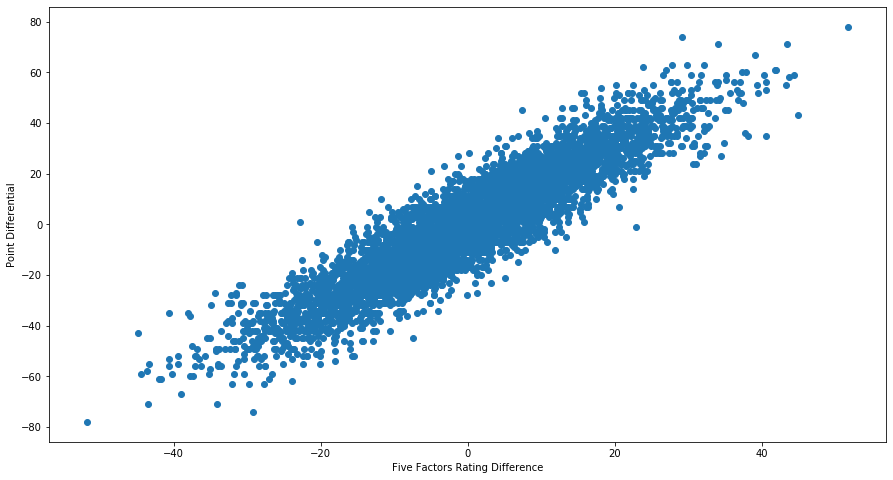

In [77]:
%matplotlib inline
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(15,8))
ax.scatter(stored_game_boxes['5FRDiff'], stored_game_boxes.PtsDiff);
ax.set_xlabel("Five Factors Rating Difference")
ax.set_ylabel("Point Differential");

In [78]:
# Eliminate outliers
from scipy import stats
import numpy as np
stored_game_boxes['5fr_z_score'] = np.abs(stats.zscore(stored_game_boxes['5FRDiff']))
stored_game_boxes['pts_z_score'] = np.abs(stats.zscore(stored_game_boxes.PtsDiff))
stored_game_boxes.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,...,OppRate,OppSR,OppPPD,ExpTO,HavocRate,ExpTODiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,Hawai'i,2016,400869090,31.0,-20.0,0.008141,0.500000,0.138889,6.652778,23.000000,...,0.416667,0.604651,6.20,1.69,0.045977,0.22,50.543808,-6.294698,0.469981,0.903174
1,California,2016,400869090,51.0,20.0,0.991859,0.528736,0.149425,7.126437,37.846154,...,0.769231,0.573333,4.80,1.47,0.083333,-0.22,56.838506,6.294698,0.469981,0.903174
0,Tulane,2016,400869421,3.0,-4.0,0.649825,0.343284,0.089552,4.179104,25.800000,...,0.400000,0.333333,0.75,0.44,0.169811,0.22,31.701271,-0.599593,0.044767,0.180635
1,Wake Forest,2016,400869421,7.0,4.0,0.350175,0.339623,0.018868,3.094340,28.363636,...,0.181818,0.555556,3.50,0.22,0.119403,-0.22,32.300864,0.599593,0.044767,0.180635
0,Charlotte,2016,400869341,14.0,-56.0,0.000059,0.250000,0.066667,3.616667,31.214286,...,0.071429,0.400000,7.00,0.98,0.057971,-0.22,35.599845,-33.627323,2.510718,2.528887


In [79]:
outliers = stored_game_boxes[(stored_game_boxes['5fr_z_score'] >= 3) | (stored_game_boxes['pts_z_score'] >= 3)]
basis = stored_game_boxes[(stored_game_boxes['5fr_z_score'] < 3) & (stored_game_boxes['pts_z_score'] < 3)]
msk = np.random.rand(len(basis)) < 0.80
train_data = basis[msk]
test_data = basis[~msk]

In [80]:
outliers

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,...,OppRate,OppSR,OppPPD,ExpTO,HavocRate,ExpTODiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,Bowling Green,2016,400869260,10.0,-67.0,0.000005,0.319444,0.041667,3.388889,22.642857,...,0.285714,0.410256,-1.000000,0.66,0.021739,0.44,26.235165,-39.077071,2.917613,3.025633
1,Ohio State,2016,400869260,77.0,67.0,0.999995,0.641304,0.097826,8.282609,31.615385,...,0.846154,0.658824,6.363636,0.22,0.111111,-0.44,65.312236,39.077071,2.917613,3.025633
0,Bowling Green,2016,400869287,3.0,-74.0,0.000002,0.297297,0.054054,3.878378,22.647059,...,0.235294,0.451613,0.750000,1.32,0.121622,0.88,28.958386,-29.189944,2.179410,3.341743
1,Memphis,2016,400869287,77.0,74.0,0.999998,0.472973,0.202703,8.189189,33.588235,...,0.588235,0.625000,7.000000,0.44,0.148649,-0.88,58.148331,29.189944,2.179410,3.341743
0,Rutgers,2016,400869635,0.0,-58.0,0.000006,0.240741,0.037037,2.222222,19.250000,...,0.000000,0.000000,0.000000,0.49,0.044944,-0.22,19.657605,-43.696475,3.262512,2.619204
1,Ohio State,2016,400869635,58.0,58.0,0.999994,0.617978,0.146067,7.516854,35.181818,...,0.909091,0.621951,5.900000,0.71,0.185185,0.22,63.354080,43.696475,3.262512,2.619204
0,Michigan,2016,400869636,78.0,78.0,0.996516,0.555556,0.152778,8.347222,41.166667,...,0.611111,0.709091,7.000000,1.20,0.277778,0.00,64.805357,51.780738,3.866107,3.522378
1,Rutgers,2016,400869636,0.0,-78.0,0.003484,0.111111,0.000000,0.703704,24.588235,...,0.058824,0.000000,0.000000,1.20,0.097222,0.00,13.024619,-51.780738,3.866107,3.522378
0,Kent State,2017,400937447,3.0,-53.0,0.000010,0.145833,0.020833,2.312500,22.250000,...,0.083333,0.333333,3.000000,0.00,0.052632,0.00,21.042560,-40.649132,3.034988,2.393411
1,Clemson,2017,400937447,56.0,53.0,0.999990,0.592105,0.118421,8.750000,30.076923,...,0.846154,0.597015,5.090909,0.00,0.104167,0.00,61.691691,40.649132,3.034988,2.393411


In [81]:
train_data.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,...,OppRate,OppSR,OppPPD,ExpTO,HavocRate,ExpTODiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,Hawai'i,2016,400869090,31.0,-20.0,0.008141,0.500000,0.138889,6.652778,23.000000,...,0.416667,0.604651,6.2,1.69,0.045977,0.22,50.543808,-6.294698,0.469981,0.903174
1,California,2016,400869090,51.0,20.0,0.991859,0.528736,0.149425,7.126437,37.846154,...,0.769231,0.573333,4.8,1.47,0.083333,-0.22,56.838506,6.294698,0.469981,0.903174
1,Wake Forest,2016,400869421,7.0,4.0,0.350175,0.339623,0.018868,3.094340,28.363636,...,0.181818,0.555556,3.5,0.22,0.119403,-0.22,32.300864,0.599593,0.044767,0.180635
1,Tennessee,2016,400868977,20.0,7.0,0.165406,0.361111,0.027778,4.388889,32.818182,...,0.454545,0.418605,4.0,2.79,0.147541,0.88,40.988693,3.008579,0.224630,0.316111
1,Florida International,2016,400869342,13.0,-21.0,0.005591,0.333333,0.101449,4.869565,30.142857,...,0.357143,0.368421,2.6,1.15,0.037037,0.66,36.908494,-12.359846,0.922824,0.948333


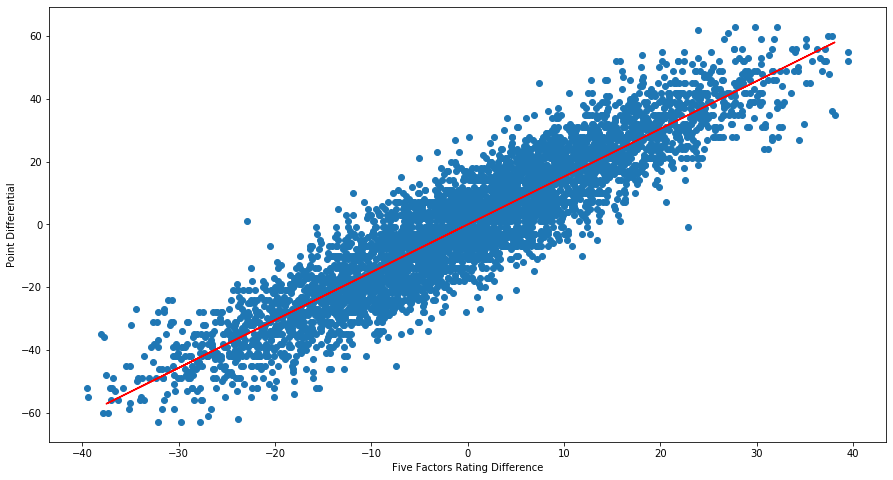

In [82]:
# Linear Regression Model
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(train_data['5FRDiff'][:, np.newaxis], train_data.PtsDiff)

f, ax = plt.subplots(figsize=(15,8))
ax.scatter(basis['5FRDiff'], basis.PtsDiff)
ax.set_xlabel("Five Factors Rating Difference")
ax.set_ylabel("Point Differential")

xfit = test_data['5FRDiff']
yfit = model.predict(xfit[:, np.newaxis])
ax.plot(xfit, yfit, color='red', label='Linear Regression');

In [83]:
print(f'Linear Regression: y = {model.coef_[0]:.5f}x + {model.intercept_:.5f}')

test = pd.DataFrame({
    'ActPtsDiff':test_data['PtsDiff'],
    'PredPtsDiff' : yfit
})

test.corr()

Linear Regression: y = 1.52358x + -0.03015


,ActPtsDiff,PredPtsDiff
ActPtsDiff,1.000000,0.917822
PredPtsDiff,0.917822,1.000000


In [84]:
def generate_win_prob(game_id, year):
    sample_box = calculate_box_score(game_id, year)
    mu = yfit.mean()
    std = yfit.std()

    max_box_row = sample_box[sample_box['PtsDiff'] == max(sample_box['PtsDiff'])]
    print(f"Actual Winner: {stringify_entry(max_box_row.Team)}")
    print(f"MOV: {stringify_entry(max_box_row.Team)} by {stringify_entry(max_box_row.PtsDiff)}")
    print(f"5FRDiff for {stringify_entry(max_box_row.Team)}: {stringify_entry(max_box_row['5FRDiff'])}")
    print("")
    proj_point_diff = model.coef_[0] * stringify_entry(max_box_row['5FRDiff']) + model.intercept_
    print(f"Proj MOV by 5FRDiff: {stringify_entry(max_box_row.Team)} by {round(proj_point_diff)} (exact value: {proj_point_diff})")
    z = (proj_point_diff - mu) / std
    print(f"Z score: {z}")
    print(f"Win Prob for {stringify_entry(max_box_row.Team)}: {(100 * stats.norm.cdf(z)):.2f}%")

In [85]:
generate_win_prob(401013183, 2018)  # 2018 UVA at VT for sample (this should be in the dataset, so not ideal)
calculate_box_score(401013183, 2018)

Actual Winner: Virginia Tech
MOV: Virginia Tech by 3.0
5FRDiff for Virginia Tech: -1.8954209929585915

Proj MOV by 5FRDiff: Virginia Tech by -3.0 (exact value: -2.9179716939316087)
Z score: -0.15167655293625268
Win Prob for Virginia Tech: 43.97%


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,PPD,OppEff,OppRate,OppSR,OppPPD,ExpTO,HavocRate,ExpTODiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,0.396825,0.111111,6.507937,26.0,2.214286,0.833333,0.428571,0.567568,5.166667,1.15,0.118421,-0.66,45.085314,1.895421
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,0.368421,0.078947,5.513158,31.4,2.266667,0.625000,0.533333,0.448980,3.375000,1.81,0.158730,0.66,43.189893,-1.895421


In [86]:
generate_win_prob(401112488, 2019)  # 2019 GT at MIA
calculate_box_score(401112488, 2019)

Actual Winner: Georgia Tech
MOV: Georgia Tech by 7.0
5FRDiff for Georgia Tech: -5.821915002560168

Proj MOV by 5FRDiff: Georgia Tech by -9.0 (exact value: -8.900297543705907)
Z score: -0.4469943727345003
Win Prob for Georgia Tech: 32.74%


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,PPD,OppEff,OppRate,OppSR,OppPPD,ExpTO,HavocRate,ExpTODiff,5FR,5FRDiff
0,Georgia Tech,2019,401112488,28.0,7.0,0.065752,0.396825,0.111111,5.460317,17.444444,3.111111,0.500000,0.444444,0.47619,3.500000,0.93,0.177419,-0.66,38.685381,-5.821915
1,Miami,2019,401112488,21.0,-7.0,0.934248,0.370968,0.112903,5.790323,38.750000,1.750000,0.333333,0.750000,0.40000,2.333333,1.59,0.158730,0.66,44.507296,5.821915


In [87]:
generate_win_prob(401112513, 2019)  # 2019 NCST at GT
calculate_box_score(401112513, 2019)

Actual Winner: Georgia Tech
MOV: Georgia Tech by 2.0
5FRDiff for Georgia Tech: 4.009669913419913

Proj MOV by 5FRDiff: Georgia Tech by 6.0 (exact value: 6.078903861745054)
Z score: 0.29245466639524215
Win Prob for Georgia Tech: 61.50%


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,PPD,OppEff,OppRate,OppSR,OppPPD,ExpTO,HavocRate,ExpTODiff,5FR,5FRDiff
0,NC State,2019,401112513,26.0,-2.0,0.156447,0.487500,0.150000,5.712500,23.700000,2.600000,0.833333,0.600000,0.552239,4.5,0.98,0.087719,0.0,46.060893,-4.00967
1,Georgia Tech,2019,401112513,28.0,2.0,0.843553,0.473684,0.140351,7.035088,29.636364,2.545455,0.571429,0.636364,0.571429,4.0,0.98,0.075000,0.0,50.070563,4.00967


In [88]:
generate_win_prob(401110863, 2019)  # 2019 Ole Miss at MSST
calculate_box_score(401110863, 2019)

Actual Winner: Mississippi State
MOV: Mississippi State by 1.0
5FRDiff for Mississippi State: 1.5985593813665702

Proj MOV by 5FRDiff: Mississippi State by 2.0 (exact value: 2.405385239968424)
Z score: 0.11111123281877329
Win Prob for Mississippi State: 54.42%


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,PPD,OppEff,OppRate,OppSR,OppPPD,ExpTO,HavocRate,ExpTODiff,5FR,5FRDiff
0,Ole Miss,2019,401110863,20.0,-1.0,0.384124,0.422535,0.084507,5.563380,25.545455,1.818182,0.60,0.454545,0.473684,4.20,1.20,0.155172,0.22,43.150251,-1.598559
1,Mississippi State,2019,401110863,21.0,1.0,0.615876,0.413793,0.137931,5.482759,31.333333,1.750000,0.75,0.333333,0.533333,5.25,0.98,0.154930,-0.22,44.748810,1.598559


In [89]:
generate_win_prob(401012356, 2018) # 2018 LSU vs TAMU  (this should be in the dataset, so not ideal)
calculate_box_score(401012356, 2018)

Actual Winner: Texas A&M
MOV: Texas A&M by 2.0
5FRDiff for Texas A&M: -4.5659073210930785

Proj MOV by 5FRDiff: Texas A&M by -7.0 (exact value: -6.98666996602928)
Z score: -0.35252805004721566
Win Prob for Texas A&M: 36.22%


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,PPD,OppEff,OppRate,OppSR,OppPPD,ExpTO,HavocRate,ExpTODiff,5FR,5FRDiff
0,LSU,2018,401012356,72.0,-2.0,0.321374,0.466667,0.088889,5.511111,46.176471,4.235294,0.916667,0.705882,0.520548,5.166667,0.49,0.134615,0.0,54.037582,4.565907
1,Texas A&M,2018,401012356,74.0,2.0,0.678626,0.423077,0.105769,4.634615,45.157895,3.894737,0.923077,0.684211,0.505882,5.000000,0.49,0.133333,0.0,49.471674,-4.565907


In [90]:
# Team Ratings by Avg Win Prob??
def calculate_avg_win_prob(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict([[tester['5FRDiff'].mean()]])
    mu = yfit.mean()
    std = yfit.std()
    z = (pred[0] - mu) / std
#     print(f"Avg Win Prob for {team}: {(100 * stats.norm.cdf(z)):.2f}%")
    return stats.norm.cdf(z)

team_wp_frame = pd.DataFrame()
for team in team_list:
    team_wp_frame = team_wp_frame.append(pd.DataFrame({
        'team':[team],
        'avg_win_prob':[calculate_avg_win_prob(team, 2019)]
    }))
team_wp_frame['proj_wins'] = round(team_wp_frame.avg_win_prob * 12.0)
team_wp_frame['proj_losses'] = 12 - team_wp_frame['proj_wins']
team_wp_frame.sort_values(by=['avg_win_prob'], ascending=False)

,team,avg_win_prob,proj_wins,proj_losses
0,Ohio State,0.957006,11.0,1.0
0,Alabama,0.936480,11.0,1.0
0,Clemson,0.925947,11.0,1.0
0,LSU,0.906496,11.0,1.0
0,Oklahoma,0.882895,11.0,1.0
0,Wisconsin,0.862360,10.0,2.0
0,Utah,0.851854,10.0,2.0
0,Memphis,0.830094,10.0,2.0
0,Minnesota,0.808861,10.0,2.0
0,Georgia,0.807977,10.0,2.0


In [91]:
# Matchup Predictor?

def predict_matchup(team1, team2, year):
    team1_avg_ffr = stored_game_boxes[(stored_game_boxes.Team == team1) & (stored_game_boxes.Season == year)]['5FR'].mean()
    team2_avg_ffr = stored_game_boxes[(stored_game_boxes.Team == team2) & (stored_game_boxes.Season == year)]['5FR'].mean()
    ffr_diff = team1_avg_ffr - team2_avg_ffr # assumes team_1 is home
#     print(f"rating diff is {ffr_diff}")
    pred = model.predict([[ffr_diff]])
    mu = yfit.mean()
    std = yfit.std()
    z = (pred[0] - mu) / std
    win_prob = stats.norm.cdf(z)
#     print(f"{team1} should beat {team2} by {pred[0]} and should win {(100 * win_prob):.2f}% of the time")
    return [win_prob, pred[0]]

predict_matchup('Georgia Tech','Clemson',2019)

[0.10218036024003302, -25.556432029844334]

In [92]:
team_triples = [
    ['Texas','Texas Tech',9.5],
    ['Virginia Tech','Virginia',2.5],
    ['Iowa','Nebraska',5.5],
    ['Missouri','Arkansas',11.5],
    ['Memphis','Cincinnati',11.5],
    ['Washington','Washington State',7.5],
    ['Georgia','Georgia Tech',28.5],
    ['Kentucky','Louisville',2.5],
    ['Clemson', 'South Carolina',27.5],
    ['Ohio State','Michigan',8.5],
    ['Indiana','Purdue',7.5],
    ['Miami','Duke',7.5],
    ['Wisconsin','Minnesota',2.5],
    ['Alabama','Auburn',3.5],
    ['Tennessee','Vanderbilt',22.5],
    ['Oregon','Oregon State',19.5],
    ['Notre Dame','Stanford',16.5],
    ['North Carolina','NC State',7.5],
    ['LSU','Texas A&M',16.5],
    ['Florida','Florida State',17.5],
    ['Utah','Colorado',17.5],
    ['Oklahoma','Oklahoma State',13.5],
    ['Arizona State','Arizona',13.5],
    ['Hawai\'i','Army',3.5]
]

bets = pd.DataFrame()

for data in team_triples:
    team1 = data[0]
    team2 = data[1]
    spread = data[2] # team 1 is always favorite
    predictor = predict_matchup(team1, team2, 2019)
    bets = bets.append(pd.DataFrame({
        "team": [team1],
        "opponent" : [team2],
        "spread" : [spread],
        "proj_MOV" : [predictor[1]],
        "proj_win_prob" : [predictor[0]],
        "proj_cover_status" : [predictor[1] > spread],
        "ats_pick": [team1 if (predictor[1] > spread) else team2]
    }))
    
bets.sort_values(by=['proj_cover_status','proj_MOV'], ascending=False)

,team,opponent,spread,proj_MOV,proj_win_prob,proj_cover_status,ats_pick
0,Alabama,Auburn,3.5,19.817706,0.834144,True,Alabama
0,Oklahoma,Oklahoma State,13.5,17.693982,0.806709,True,Oklahoma
0,LSU,Texas A&M,16.5,17.085667,0.798367,True,LSU
0,Ohio State,Michigan,8.5,11.174116,0.706772,True,Ohio State
0,Hawai'i,Army,3.5,7.527344,0.642055,True,Hawai'i
0,Clemson,South Carolina,27.5,20.845063,0.846464,False,South Carolina
0,Georgia,Georgia Tech,28.5,14.175427,0.755575,False,Georgia Tech
0,Notre Dame,Stanford,16.5,10.820228,0.700733,False,Stanford
0,Memphis,Cincinnati,11.5,10.632695,0.697510,False,Cincinnati
0,Utah,Colorado,17.5,9.271673,0.673669,False,Colorado


In [93]:
generate_win_prob(401112521, 2019)  # 2019 VT @ UVA
calculate_box_score(401112521, 2019)

Could not find basic game data for game_id 401112521 locally, checking CFB Data API
Could not find drive data for game_id 401112521 locally, checking CFB Data API
Could not find play by play data for game_id 401112521 locally, checking CFB Data API
Actual Winner: Virginia
MOV: Virginia by 9
5FRDiff for Virginia: 7.595202193827873

Proj MOV by 5FRDiff: Virginia by 12.0 (exact value: 11.541747404567944)
Z score: 0.5621282156931723
Win Prob for Virginia: 71.30%
Could not find basic game data for game_id 401112521 locally, checking CFB Data API
Could not find drive data for game_id 401112521 locally, checking CFB Data API
Could not find play by play data for game_id 401112521 locally, checking CFB Data API


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,PPD,OppEff,OppRate,OppSR,OppPPD,ExpTO,HavocRate,ExpTODiff,5FR,5FRDiff
0,Virginia Tech,2019,401112521,30,-9,0.577256,0.394231,0.153846,5.788462,31.600000,2.0,0.857143,0.466667,0.588235,4.285714,1.15,0.088608,0.44,44.873798,-7.595202
1,Virginia,2019,401112521,39,9,0.422744,0.367089,0.240506,9.481013,26.692308,3.0,0.857143,0.538462,0.478261,4.857143,0.71,0.115385,-0.44,52.469000,7.595202


In [94]:
generate_win_prob(401112475, 2019) # 2019 UNC at GT
calculate_box_score(401112475, 2019)

Actual Winner: North Carolina
MOV: North Carolina by 16.0
5FRDiff for North Carolina: 3.4478054591505867

Proj MOV by 5FRDiff: North Carolina by 5.0 (exact value: 5.2228586874431615)
Z score: 0.2501959528326595
Win Prob for North Carolina: 59.88%


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,PPD,OppEff,OppRate,OppSR,OppPPD,ExpTO,HavocRate,ExpTODiff,5FR,5FRDiff
0,North Carolina,2019,401112475,38.0,16.0,0.98905,0.457447,0.106383,5.744681,29.153846,2.923077,0.857143,0.538462,0.507692,5.428571,1.86,0.207547,0.0,48.066689,3.447805
1,Georgia Tech,2019,401112475,22.0,-16.0,0.01095,0.396226,0.150943,6.094340,26.923077,1.692308,0.750000,0.307692,0.631579,5.250000,1.86,0.127660,0.0,44.618883,-3.447805


In [95]:
generate_win_prob(401112498, 2019) # 2019 Pitt at GT
calculate_box_score(401112498, 2019)

Actual Winner: Pittsburgh
MOV: Pittsburgh by 10.0
5FRDiff for Pittsburgh: 11.930340363570178

Proj MOV by 5FRDiff: Pittsburgh by 18.0 (exact value: 18.146675126799256)
Z score: 0.8881808085869456
Win Prob for Pittsburgh: 81.28%


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,PPD,OppEff,OppRate,OppSR,OppPPD,ExpTO,HavocRate,ExpTODiff,5FR,5FRDiff
0,Pittsburgh,2019,401112498,20.0,10.0,0.970074,0.362319,0.057971,5.086957,35.285714,1.428571,0.666667,0.428571,0.470588,3.333333,1.91,0.183673,0.0,41.086306,11.93034
1,Georgia Tech,2019,401112498,10.0,-10.0,0.029926,0.204082,0.061224,3.591837,31.769231,0.769231,0.500000,0.307692,0.263158,2.500000,1.91,0.144928,0.0,29.155965,-11.93034
